In [2]:
# load required libraries
import matplotlib.pyplot as plt # for visualization 
import pandas as pd # for data loading and pre processing
import numpy as np # for matrix operations
from IPython.display import HTML # for graph display
%matplotlib inline

## Generate Random data of given shape

In [2]:
def generate_data(shape):
    y = np.zeros((shape[0], 1))
    mu, sigma = 0, 0.01
    x = np.zeros((shape[0],shape[1]))
    t = np.arange(shape[0]).T
    coeff = np.random.randint(1, 9, size=shape[1])
    print "coefficients used to construct y are: {}".format(coeff)
    noise = np.random.normal(mu, sigma, (shape[0], 1))
    
    for col in range(shape[1]):
        x[:,col] = np.random.randint(1, 100, size=shape[0]).T
        y[:] += coeff[col]*x[:,col].reshape(shape[0], 1)
    
    y = y + noise
    index = np.random.randint(0, shape[0], size=shape[0])
    y, x = y[index], x[index]
    
    return (x[int(shape[0]*0.7):], y[int(shape[0]*0.7):]),\
            (x[:int(shape[0]*0.7)], y[:int(shape[0]*0.7)])

In [21]:
class linear_regression(object):
    def __init__(self, alpha, n_features, plot = True):
        self.alpha = alpha
        self.n_features = n_features
        self.w0 = np.random.rand(1)
        self.weights = np.random.rand(self.n_features)
        self.plot = plot
           
    def visualization(self, X, Y, losses):
        if self.n_features == 1: 
            Ypred = np.matmul(X, self.weights.T) + self.w0
            plt.subplot(1, 2, 1)
            plt.plot(X, Y, 'r', X, Ypred, 'b')
            plt.title('2D Data distribution, True and Predicted data')
            plt.ylabel('Y values')
            plt.xlabel('X values')

            t = np.arange(len(losses))
            plt.subplot(1, 2, 2)
            plt.plot(t, losses)
            plt.xlabel('steps')
            plt.ylabel('Loss')

            plt.show()

            print "Red line in plot1 shows true values, \
                blue line predicted values."
        else:
            t = np.arange(len(losses))
            plt.plot(t, losses)
            plt.xlabel('steps')
            plt.ylabel('Loss')
            plt.show()      
        pass
    
    def forward(self, input):
        self.input = np.array(input)
        # print self.input.shape, self.weights.T.shape, self.w0.shape
        self.output = np.matmul(self.input, self.weights.T) + self.w0
        self.output = np.expand_dims(self.output, axis = 1)
    
    
    def loss(self, labels):
        # RMS
        loss = np.mean((labels - self.output)**2)
        return loss

    
    def gradients(self, labels):
        # print self.output.shape, labels.shape
        diff = self.output - labels
        self.grad_w0 = 2*np.sum(diff)/labels.shape[0]
        self.grad_w = 2*np.matmul(diff.T ,self.input)/labels.shape[0]
       
    
    def predict(self, X):
        output = np.matmul(self.input, self.weights.T) + self.w0
        return output
    
    
    def batch_gradient_descent(self, X, Y, thresh=0.2):
        self.forward(X)
        loss = self.loss(Y)
        step = 0
        if self.plot: losses = []
        
        while loss >= thresh:
            self.gradients(Y)
            
            # update            
            self.w0 -= np.squeeze(self.alpha*self.grad_w0)
            self.weights -= np.squeeze(self.alpha*self.grad_w)
            
            self.forward(X)
            loss = self.loss(Y)
            losses.append(loss)
            if step % 1000000 == 0: print "Batch number: {}".format(step)+" current loss: {}".format(loss)
            # +" current weights: {}".format([self.weights, self.w0])
            step += 1
        if self.plot : self.visualization(X, Y, losses)
        pass
    
    
    def SGD(self, X, Y, batch_size, thresh=1):
        loss = 100
        step = 0
        if self.plot: losses = []
            
        while loss >= thresh:
            # mini_batch formation
            index = np.random.randint(0, len(X), size = batch_size)
            trainX, trainY = np.array(X)[index], np.array(Y)[index]
            
            self.forward(trainX)
            loss = self.loss(trainY)
            self.gradients(trainY)
            
            # update            
            self.w0 -= np.squeeze(self.alpha*self.grad_w0)
            self.weights -= np.squeeze(self.alpha*self.grad_w)
            
            losses.append(loss)
            if step % 1000 == 999: print "Batch number: {}".format(step)+" current loss: {}".format(loss)
            step += 1
        if self.plot : self.visualization(X, Y, losses)
        pass
    
    
    def SGD_with_momentum(self, X, Y, batch_size, thresh=1, momentum = 0.9):
        loss = 100
        step = 0
        if self.plot: losses = []
            
        delta_w, delta_w0 = np.zeros_like(self.weights), 0
        
        while loss >= thresh: 
            # mini_batch formation
            index = np.random.randint(0, len(X), size = batch_size)
            trainX, trainY = np.array(X)[index], np.array(Y)[index]
            
            self.forward(trainX)
            loss = self.loss(trainY)
            self.gradients(trainY)
            
            # update delta_w using momentum
            delta_w = momentum*delta_w - self.alpha*self.grad_w
            delta_w0 = momentum*delta_w0 - self.alpha*self.grad_w0
            
            # update parameters
            self.w0 += np.squeeze(delta_w0)
            self.weights += np.squeeze(delta_w)
            
            losses.append(loss)
            if step % 1000 == 0: print "Batch number: {}".format(step)+" current loss: {}".format(loss)
            step += 1
        if self.plot : self.visualization(X, Y, losses)
        pass
    
    
    def AdaGrad(self, X, Y, batch_size, thresh = 0.5, epsilon = 1e-6):
        loss = 100
        step = 0
        if self.plot: losses = []
        G = np.zeros((X.shape[1], X.shape[1]))
        G0 = 0
        while loss >= thresh: 
            # mini_batch formation
            index = np.random.randint(0, len(X), size = batch_size)
            trainX, trainY = np.array(X)[index], np.array(Y)[index]
            
            self.forward(trainX)
            loss = self.loss(trainY)
            self.gradients(trainY)

            G += self.grad_w.T*self.grad_w
            G0 += self.grad_w0**2
            den = np.sqrt(np.diag(G)+epsilon)
            
            delta_w = self.alpha*self.grad_w / den
            delta_w0 = self.alpha*self.grad_w0 / np.sqrt(G0 + epsilon)
            
            # update parameters
            self.w0 -= np.squeeze(delta_w0)
            self.weights -= np.squeeze(delta_w)
            
            losses.append(loss)
            if step % 500 == 0: print "Batch number: {}".format(step)+" current loss: {}".format(loss)
            step += 1
        if self.plot : self.visualization(X, Y, losses)
        pass
    
    
    def RMSProp(self, X, Y, batch_size, thresh = 0.1,epsilon = 1e-4, forget= 0.9):
        loss = 100
        step = 0
        if self.plot: losses = []
        G = np.zeros((X.shape[1], X.shape[1]))
        G0 = 0
        while step < 270000: 
            # mini_batch formation
            index = np.random.randint(0, len(X), size = batch_size)
            trainX, trainY = np.array(X)[index], np.array(Y)[index]
            
            self.forward(trainX)
            loss = self.loss(trainY)
            self.gradients(trainY)

            G = forget * G + (1-forget) * self.grad_w.T*self.grad_w
            G0 = forget * G0 + (1-forget)  * self.grad_w0**2
            den = np.sqrt(np.diag(G) + epsilon)
            
            delta_w = self.alpha*self.grad_w / den
            delta_w0 = self.alpha*self.grad_w0 / np.sqrt(G0 + epsilon)
            
            # update parameters
            self.w0 -= np.squeeze(delta_w0)
            self.weights -= np.squeeze(delta_w)
            
            losses.append(loss)
            if step % 5000 == 0: print "Batch number: {}".format(step)+" current loss: {}".format(loss)
            step += 1
        if self.plot : self.visualization(X, Y, losses)        
        pass
    
    def coeff(self):
        return self.weights, self.w0

In [5]:
n_features = 5
(trainX, trainY),(testX, testY) = generate_data((100, n_features))

coefficients used to construct y are: [6 5 4 4 2]


Batch number: 0 current loss: 1003756.98151


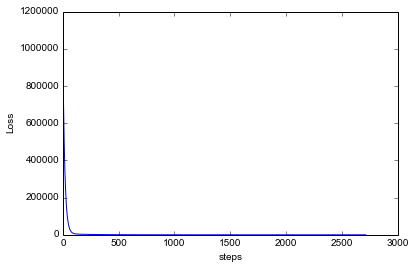

(array([ 5.99206039,  4.99453494,  4.01561621,  3.99494125,  1.9992196 ]),
 array([ 0.09544154]))

In [6]:
# batch gradient descent implementation
def batch_gradient_descent(trainX, trainY, thresh=1e-5):
    reg = linear_regression(1e-6, n_features=n_features)
    # fitting model
    reg.batch_gradient_descent(trainX, trainY)
    return reg.coeff()

batch_gradient_descent(trainX, trainY)

Batch number: 999 current loss: 47.0380794174


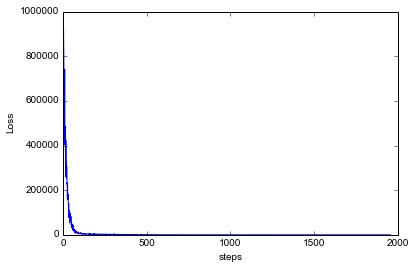

(array([ 5.94789395,  4.99232258,  4.07179402,  3.9777618 ,  1.99554409]),
 array([ 0.32801827]))

In [7]:
# batch gradient descent implementation
def SGD(trainX, trainY, batch_size):
    reg = linear_regression(1e-6, n_features)
    # fitting model
    reg.SGD(trainX, trainY, batch_size)
    return reg.coeff()

SGD(trainX, trainY, 10)

Batch number: 0 current loss: 1256625.63719
Batch number: 1000 current loss: 26.535624196


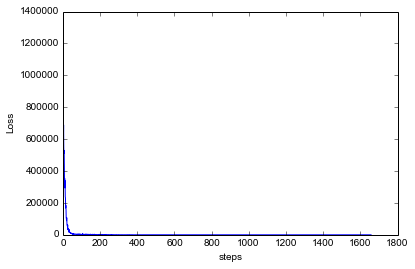

(array([ 5.99490679,  4.98500377,  4.04552582,  3.9534315 ,  2.0129719 ]),
 array([ 0.31678457]))

In [8]:
def SGD_momentum(trainX, trainY, batch_size):
    reg = linear_regression(1e-6, n_features)
    # fitting model
    reg.SGD_with_momentum(trainX, trainY, batch_size, momentum = 0.5)
    return reg.coeff()

SGD_momentum(trainX, trainY,10)

Batch number: 0 current loss: 863267.134528
Batch number: 500 current loss: 5.72403956967


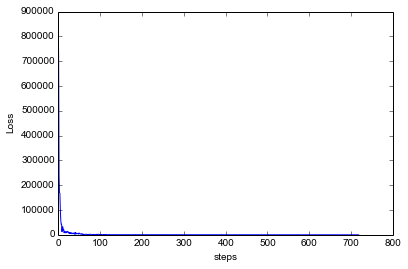

(array([ 5.97066877,  4.9851593 ,  4.01876013,  3.97252574,  1.97905412]),
 array([ 3.79031857]))

In [9]:
def Adagrad(trainX, trainY, batch_size):
    reg = linear_regression(1, n_features)
    # fitting model
    reg.AdaGrad(trainX, trainY, batch_size)
    return reg.coeff()

Adagrad(trainX, trainY,10)

Batch number: 0 current loss: 1.38155177723


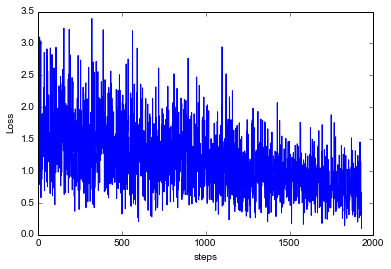

(array([ 0.11982732, -1.1033754 , -0.36085632,  0.0774503 ,  0.61020535,
         0.39301469,  0.388237  ]), array([ 0.82280033]))

In [20]:
def RMSprop(trainX, trainY, batch_size):
    reg = linear_regression(0.001, n_features)
    # fitting model
    reg.RMSProp(trainX, trainY, batch_size, forget = 0.9)
    return reg.coeff()

RMSprop(trainX, trainY, 10)